In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob # used for path matching
import os
import sys
from PIL import Image

In [2]:
originals_path = glob.glob("input/isbi2015/train/image/*.png") # get image paths
masks_path = glob.glob("input/isbi2015/train/label/*.png")

print(type(originals_path))
print(type(masks_path))

<class 'list'>
<class 'list'>


In [3]:
org_list=[]
mask_list=[]

for (org,mask) in zip(originals_path,masks_path):
    
    org_list.append(np.array(Image.open(org).resize((512,512))))
    
    mask_list.append(np.array(Image.open(mask).resize((512,512))))
    
org_np=np.asarray(org_list) # convert list into array
mask_np=np.asarray(mask_list)

In [4]:
print(org_np.shape,mask_np.shape)

(30, 512, 512) (30, 512, 512)


In [5]:
print(org_np.shape[1]) # size of image

512


Using TensorFlow backend.


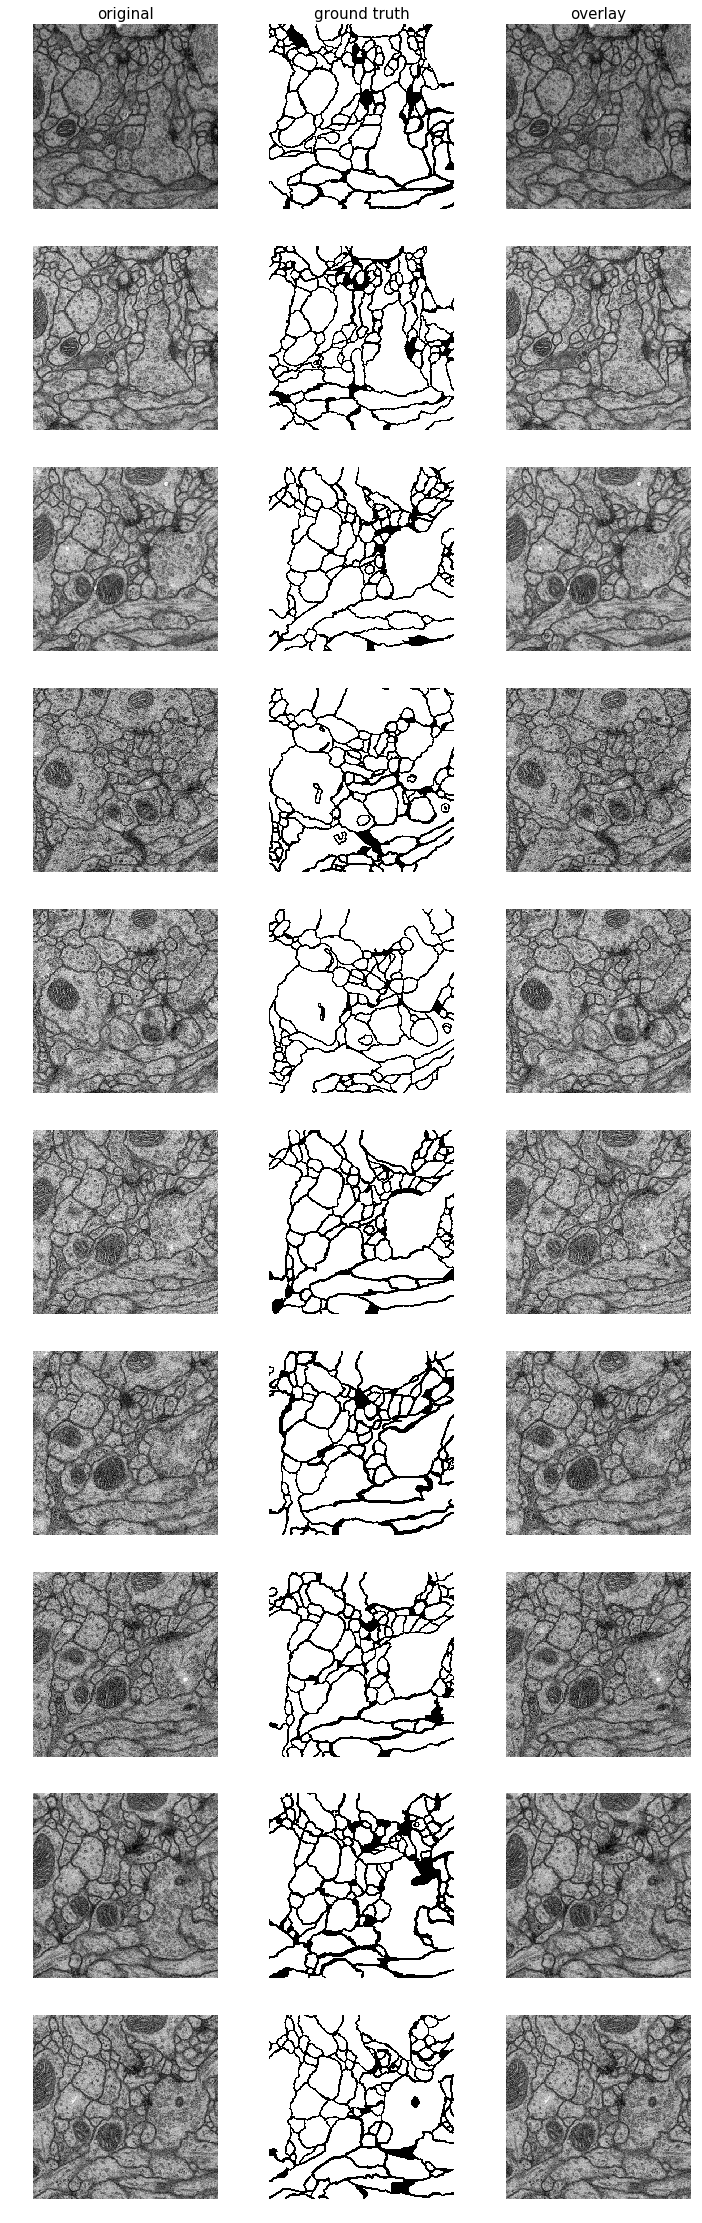

In [6]:
from tanuj_utils.utils_ import plot_imgs

plot_imgs(org_np,mask_np) # plot images

In [6]:
# convert the values in image arrays to float

# reduce the range of values in the image arrays by dividing by 255

x = np.asarray(org_np, dtype=np.float32)/255
y = np.asarray(mask_np, dtype=np.float32)/255

# proper shape

x = np.reshape(x,(x.shape[0],x.shape[1],x.shape[2],1))
y = np.reshape(y,(y.shape[0],y.shape[1],y.shape[2],1))

In [7]:
print(x.shape,y.shape)

(30, 512, 512, 1) (30, 512, 512, 1)


In [8]:
# train-test split

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (15, 512, 512, 1)
y_train:  (15, 512, 512, 1)
x_val:  (15, 512, 512, 1)
y_val:  (15, 512, 512, 1)


In [9]:
# data augmentation

from tanuj_utils.utils_ import augment_data

train_gen = augment_data(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))


Using TensorFlow backend.


(2, 512, 512, 1) (2, 512, 512, 1)


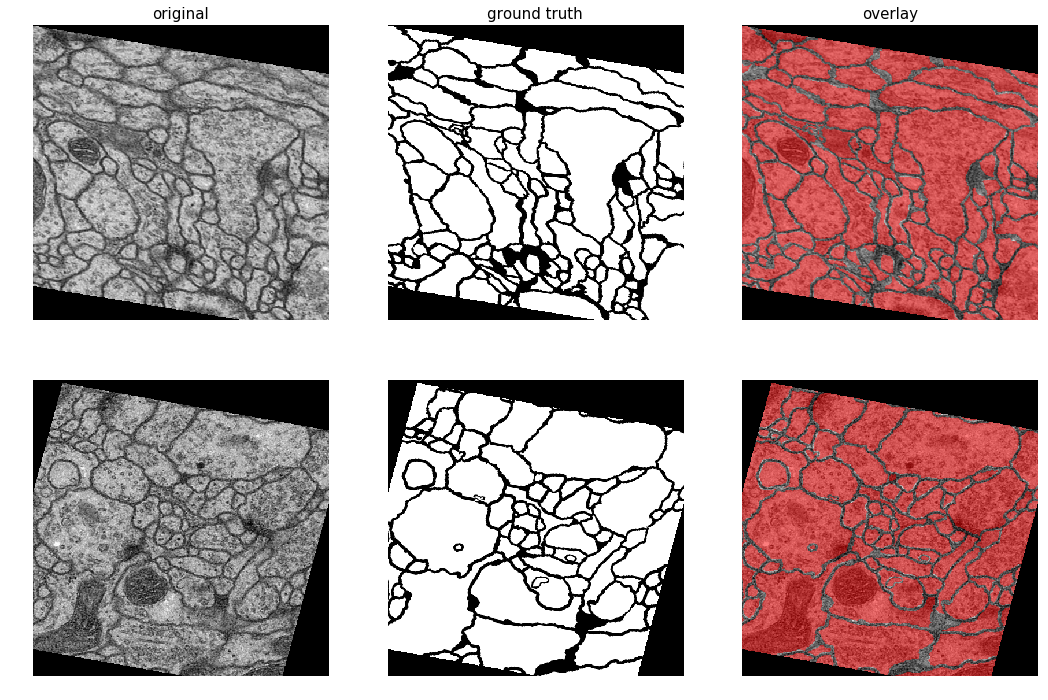

In [10]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from tanuj_utils.utils_ import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [11]:
from tanuj_utils.model import unet 

input_shape = x_train[0].shape

model = unet(input_shape,
             use_batch_norm=False,
             num_classes=1,
             filters=64,
             dropout=0.2,
             output_activation='sigmoid')

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin